In [1]:
import json
import string
from collections import defaultdict
from sklearn import linear_model
from matplotlib import pyplot as plt
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error

**loading datasets (train, valid, test)**

In [2]:
dataset = json.load(open('filter_all_t.json'))
trainSet = dataset['train']
valSet = dataset['val']
testSet = dataset['test']
len(trainSet)

87013

## Exploratory Analysis

**Determing the distribution of ratings (y) in the database**

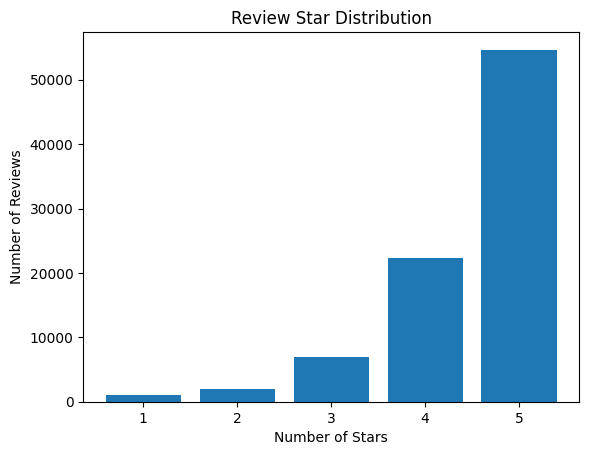

In [3]:
ratingsList = [d['rating'] for d in trainSet]
numOfStars = defaultdict(int)
for d in trainSet:
    numOfStars[d['rating']] += 1
    
plt.bar(list(numOfStars.keys()), list(numOfStars.values()))
plt.title('Review Star Distribution')
plt.xlabel('Number of Stars')
plt.ylabel('Number of Reviews')
plt.show()

**Average rating score**

In [4]:
avgRatingScore = sum(ratingsList) / len(ratingsList)
avgRatingScore

4.465252318619057

**Average number of `history_reviews` per review**

In [5]:
histReviews = [len(d['history_reviews']) for d in trainSet]
sum(histReviews) / len(histReviews)

3.3998368059945068

**Average number of pictures per review**

In [6]:
numOfPictures = [len(d['pics']) for d in trainSet]
sum(numOfPictures) / len(numOfPictures)

1.8681001689402732

**Checking for overlapping users between the sets**

In [7]:
usersTrain = set()
restaurantsTrain = set()

for d in trainSet:
    usersTrain.add(d['user_id'])
    restaurantsTrain.add(d['business_id'])

usersValid = set()
restaurantsValid = set()

for d in valSet:
    usersValid.add(d['user_id'])
    restaurantsValid.add(d['business_id'])

# usersTest = set()
# restaurantsTest = set()

# for d in testSet:
#     usersTest.add(d['user_id'])
#     restaurantsTest.add(d['business_id'])

print("number of overlapping users between train and valid set: ", len(usersTrain.intersection(usersValid)))
print("number of overlapping restaurants between train and valid set: ", len(restaurantsTrain.intersection(restaurantsValid)))

number of overlapping users between train and valid set:  0
number of overlapping restaurants between train and valid set:  6282


## Model

**Bag-of-Words model**

In [8]:
reviewWordCount = defaultdict(int)
punctuation = set(string.punctuation)

# getting all words that are not punctuation, making sure upper/lower case doesn't matter
for d in trainSet:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  for w in r.split():
    reviewWordCount[w] += 1

print("number of unqiue review words: ", len(reviewWordCount))
reviewCounts = [(reviewWordCount[w], w) for w in reviewWordCount]
reviewCounts.sort(reverse=True)

# top 3000 most popular words from reviewCounts
reviewWords = [x[1] for x in reviewCounts[:3000]]
reviewWordId = dict(zip(reviewWords, range(len(reviewWords)))) 

number of unqiue review words:  38456


**Sentiment Analysis**

In [12]:
def feature(datum):
    vector1 = [0]*len(reviewWords)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    for w in r.split():
        if w in reviewWords:
            vector1[reviewWordId[w]] += 1

    return vector1 + [len(datum['pics'])] + [len(datum['history_reviews'])] + [1] 

X = [feature(d) for d in trainSet]
y = [d['rating'] for d in trainSet]

# Regularized regression
model = linear_model.Ridge(1.0, fit_intercept=False)
model.fit(X, y)
xVal, yVal = [feature(d) for d in valSet], [d['rating'] for d in valSet]
predVal = model.predict(xVal)

for i in range(len(predVal)):
    if predVal[i] > 5: predVal[i] = 5
    elif predVal[i] < 1: predVal[i] = 1
    else: predVal[i] = round(predVal[i])


MAE = mean_absolute_error(yVal, predVal)
print("Valid MAE: ", str(MAE))

xTest, yTest = [feature(d) for d in testSet], [d['rating'] for d in testSet]
predTest = model.predict(xTest)

for i in range(len(predTest)):
    if predTest[i] > 5: predTest[i] = 5
    elif predTest[i] < 1: predTest[i] = 1
    else: predTest[i] = round(predTest[i])

MAE = mean_absolute_error(yTest, predTest)
print("Test MAE: ", str(MAE))

Valid MAE:  0.4778084714548803
Test MAE:  0.4667271901951884


In [10]:
avgRatingList = [avgRatingScore for _ in yVal]
baseline = mean_absolute_error(yVal, avgRatingList)
print("baseline: ", baseline)

baseline:  0.6807998737048648


**10 most negatively weighted words and 10 most positively weighted words**

In [11]:
theta = model.coef_
wordsWeight = [(theta[i], reviewWords[i]) for i in range(len(reviewWords))]
wordsWeight.sort()
table = wordsWeight[:15]
print("Bottom Weighted Words")
print(tabulate(table, headers=('weight', 'word'), tablefmt='fancy_grid'))
wordsWeight.sort(reverse=True)
table = wordsWeight[:15]
print("Top Weighted Words")
print(tabulate(table, headers=('weight', 'word'), tablefmt='fancy_grid'))

Bottom Weighted Words
╒═══════════╤════════════╕
│    weight │ word       │
╞═══════════╪════════════╡
│ -1.27357  │ disgusting │
├───────────┼────────────┤
│ -1.21159  │ worst      │
├───────────┼────────────┤
│ -1.00238  │ horrible   │
├───────────┼────────────┤
│ -0.958313 │ awful      │
├───────────┼────────────┤
│ -0.862087 │ edible     │
├───────────┼────────────┤
│ -0.833706 │ mediocre   │
├───────────┼────────────┤
│ -0.806961 │ gross      │
├───────────┼────────────┤
│ -0.769495 │ tasteless  │
├───────────┼────────────┤
│ -0.76202  │ terrible   │
├───────────┼────────────┤
│ -0.722363 │ sent       │
├───────────┼────────────┤
│ -0.722222 │ stale      │
├───────────┼────────────┤
│ -0.690482 │ burned     │
├───────────┼────────────┤
│ -0.689473 │ flavorless │
├───────────┼────────────┤
│ -0.635109 │ supposed   │
├───────────┼────────────┤
│ -0.617519 │ overpriced │
╘═══════════╧════════════╛
Top Weighted Words
╒══════════╤═════════════╕
│   weight │ word        │
╞══════════╪══